# Malaria Cells Classification Using CNN 
Last editing date: 2020.09.28. [GitHub](https://github.com/YC-1412/AML_projects/tree/master/CNN-malaria_cells_classification)

This sample shows a classification of Malaria cells using CNN. It is modified from a homework I did with one of my classmates (Bo Jumrustanasan) on the course COMS 4995 Applied Machine Learning by Dr. Andreas C. Müller at Columbia University. The dataset is [Malaria Dataset](https://lhncbc.nlm.nih.gov/publication/pub9932). The sample includes the following work:
1. data preparation: downloading, resizing, train_test_split
2. data agumentation
3. CNN building and training
4. model evaluation

## 1. Data Preparation
### 1.1 Load Packages and Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import os
import imageio
from random import shuffle
import pickle

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, \
            Activation, BatchNormalization
from keras.models import Model
from keras import utils

In [1]:
# ## Get the data to the drive
! wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
! unzip cell_images.zip

In [ ]:
# delete useless files
!find . -type f   -wholename "./cell_images/Uninfected/*.db"  -delete
!find . -type f   -wholename "./cell_images/Parasitized/*.db"  -delete

### 1.2 Resize and Split Data 

To save space, we resized the images to 150 by 150 pixels. One image corresponds to a (150,150,3) matrix. The training data size is 24940. The testing data size is 2754 (10% of the total sample size).


In [ ]:
def resize_image(image_array, image_height, image_width):
  '''
  resize image by chopping or padding
  Args:
    image_array: image matrix
    image_height, image_width: wanted size
  Return:
    processed_image: processed image of wanted size  
  '''
  # resize the image, if larger chop, if smaller stay same
  resize_image = image_array[:image_height, :image_width, :]
  original_size = resize_image.shape
  # pad image if smaller than the size
  processed_image = np.pad(resize_image, ((0, image_height - original_size[0]),
                                          (0, image_width - original_size[1]),
                                          (0, 0)), 
                                       'constant', constant_values=0)
  return processed_image

In [ ]:
path_unin='./cell_images/Uninfected/'
path_in='./cell_images/Parasitized/'
lists_unin = os.listdir(path_unin)
lists_in = os.listdir(path_in)

image_height = 150
image_width = 150

uninfected_list = []
infected_list = []
original_list = [] ##
for i in range(len(lists_unin)):
    file_path = lists_unin[i]
    im = imageio.imread(os.path.join(path_unin, file_path))
    original_list.append(im) ##
    uninfected_list.append((resize_image(im, image_height, image_width), 0))

for i in range(len(lists_in)):
    file_path = lists_in[i]
    im = imageio.imread(os.path.join(path_in, file_path))
    original_list.append(im) ##
    infected_list.append((resize_image(im, image_height, image_width), 1))

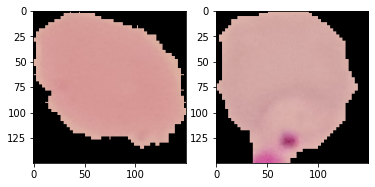

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(uninfected_list[0][0]);
ax[1].imshow(infected_list[0][0]);

In [ ]:
def train_test_split(class_0_list, class_1_list, test_split=0.1):

    #' class_0_list and class_0_list are lists of ordered paris whose
    #' first element is an image and the second is either 0 or 1.

    ## Shuffle elements in the lists
    shuffle(class_0_list)
    shuffle(class_1_list)

    ## Get indices for train and test sets
    total_class_0 = len(class_0_list)
    index_test = np.random.randint(0, total_class_0, 
                                   int(total_class_0*test_split))
    index_train = list(set(range(total_class_0)) - set(index_test))

    ## Get images for train and test sets using the indices and shuffle
    train_list = [class_0_list[i] for i in index_train] + [class_1_list[i] for i in index_train]
    shuffle(train_list)
    test_list = [class_0_list[i] for i in index_test] + [class_1_list[i] for i in index_test]
    shuffle(test_list)

    ## Separate features and targets into matrices
    total_train = len(train_list)
    total_test = len(test_list)

    X_train = np.ndarray((total_train, image_width, image_height, 3), 
                    dtype=np.uint8)
    X_test = np.ndarray((total_test, image_width, image_height, 3), 
                    dtype=np.uint8)
    y_train = np.array([None]*total_train)
    y_test = np.array([None]*total_test)

    for i in range(len(train_list)):
        X_train[i] = train_list[i][0]
        y_train[i] = train_list[i][1]

    for i in range(len(test_list)):
        X_test[i] = test_list[i][0]
        y_test[i] = test_list[i][1]

    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, \
    y_train, y_test = train_test_split(uninfected_list, infected_list, 
                                       test_split=0.1)

In [ ]:
# # to save space for future storage
# del globals()["uninfected_list"]
# del globals()["infected_list"]
# del globals()["im"]

In [ ]:
num_classes = 2

y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

## 2. A Convolutional model without residual connections


### 2.1 Data augmentation

We centered, standardized, horizontally mirrored, randomly rotated up to 20 degrees, and shifted horizontally and vertically by 20% of the data.



In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow(
    (X_train,y_train),
    batch_size=32,
    subset='training')

validation_generator = datagen.flow(
    (X_train,y_train),
    batch_size=32,
    subset='validation')

### 2.2 Model building 
We create a convolutional network with 5 hidden layers (4 convolutional layers and 1 dense layer). Each convolution layer has 32 feature maps (kernel_szie=(3,3)). The dense layer has 64 units. We did batch normalization after each convolution layer to accelerate training and maxpooling (pool_size=(2,2)) after every two convolutional layers.

The model is trained for 50 epoches with batch_size=32 and validation_split=0.2. The validation accuracy is about 0.93.


Compared with using unaugmented data (validation accuracy is about 0.93, I removed the code because the model is the same), the accuracy of the model using augmented data increases to about 0.94. This tiny improvement is reasonable given the validation accuracy using the original data is alread high.

In [ ]:
## construct the same model as in 3.1
model_2_augment = Sequential()
model_2_augment.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_augment.add(BatchNormalization())
model_2_augment.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_augment.add(BatchNormalization())
model_2_augment.add(MaxPooling2D(pool_size=(2, 2)))
model_2_augment.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_augment.add(BatchNormalization())
model_2_augment.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_2_augment.add(BatchNormalization())
model_2_augment.add(MaxPooling2D(pool_size=(2, 2)))
model_2_augment.add(Flatten())
model_2_augment.add(Dense(64, activation='relu'))
model_2_augment.add(Dense(num_classes, activation='softmax'))

In [ ]:
## change parameters
model_2_augment.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

# fits the model on batches with real-time data augmentation:
history_2_augmented = model_2_augment.fit_generator(train_generator,
                           steps_per_epoch = len(X_train)*0.8 / 32,
                           validation_data = validation_generator,
                           validation_steps = len(X_train)*0.2 / 32,
                           epochs=50)

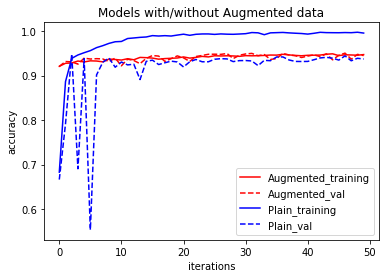

In [ ]:
fig,ax=plt.subplots(1,1)
ax.plot(history_2_augmented.history['accuracy'],label='Augmented_training',color='red')
ax.plot(history_2_augmented.history['val_accuracy'],label='Augmented_val',color='red',linestyle='dashed')
ax.plot(history_1.history['accuracy'],label='Plain_training',color='blue')
ax.plot(history_1.history['val_accuracy'],label='Plain_val',color='blue',linestyle='dashed')
ax.legend();
ax.set_title('Models with/without Augmented data');
ax.set_xlabel('iterations');
ax.set_ylabel('accuracy');